# Load Packages

In [4]:
%load_ext autoreload
%autoreload 2

import sys
from os.path import join
from tqdm.auto import tqdm
import joblib
sys.path.append("../../")

from src.file_manager.load_data import load_split_dict
from src.models.rue.tuning import model_tuning_regressor, model_tuning_decoder
from src.models.rue.training import model_training_predictor, model_training_decoder
from src.models.rue.save_load_model import save_model, load_model
from src.models.rue.predicting import model_test_predictions
from src.misc import create_folder
from seed_file import seed

# seed = 2023
tuning_seed = 2023
data_label = "physionet"
batch_size = 64

# File paths
fp_notebooks_folder = "../"
fp_project_folder = join(fp_notebooks_folder, "../")
fp_data_folder = join(fp_project_folder, "../", "data")
fp_output_data_folder = join(fp_data_folder, data_label)
fp_checkpoint_folder = join(fp_project_folder, "checkpoints")
fp_project_checkpoints = join(fp_checkpoint_folder, data_label)
fp_tuning = join(fp_project_checkpoints, "tuning")
fp_models = join(fp_project_checkpoints, "models")
fp_predictions = join(fp_project_checkpoints, "predictions")

# Seed filepaths
fp_cur_tune_folder = join(fp_tuning, str(tuning_seed))
create_folder(fp_cur_tune_folder)
fp_cur_model_folder = join(fp_models, str(seed))
create_folder(fp_cur_model_folder)
fp_cur_predictions_folder = join(fp_predictions, str(seed))
create_folder(fp_cur_predictions_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [5]:
split_dict = load_split_dict(fp_output_data_folder)

# Tune and Train Predictor

## Tune

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000


182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0152 - val_loss: 0.0025
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0032 - val_loss: 0.0023
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0029 - val_loss: 0.0024
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 12/1000

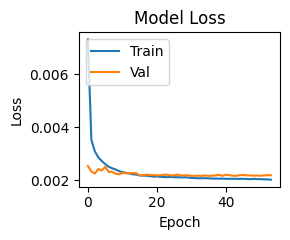

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0130 - val_loss: 0.0024
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0023 - val_loss: 0.0022
E

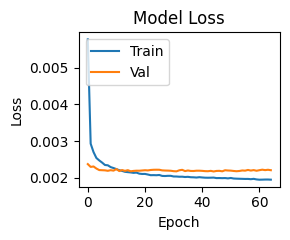

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0107 - val_loss: 0.0023
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.0022 - val_loss: 0.0023
E

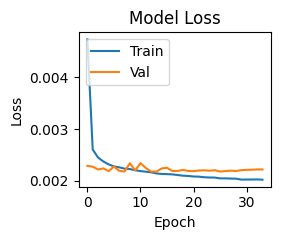

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0128 - val_loss: 0.0025
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 0.0028 - val_loss: 0.0022
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - val_loss: 0.0022
Epo

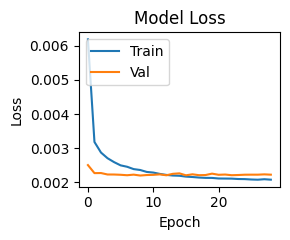

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0099 - val_loss: 0.0024
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0022 - val_loss: 0.0022
E

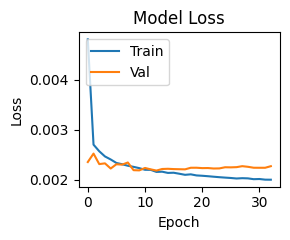

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0074 - val_loss: 0.0027
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0022 - val_loss: 0.0023
E

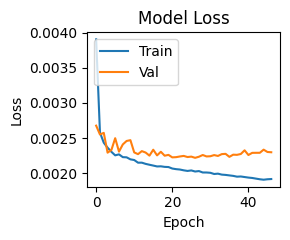

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0129 - val_loss: 0.0025
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.0033 - val_loss: 0.0024
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0023 - val_loss: 0.0022
Epoch

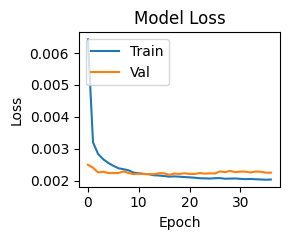

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0113 - val_loss: 0.0023
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0022 - val_loss: 0.0022
E

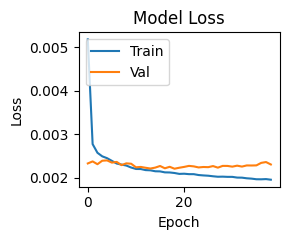

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0084 - val_loss: 0.0025
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0022 - val_loss: 0.0024
E

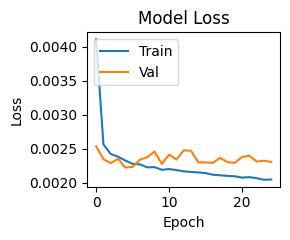

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,epochs,time/s,best_hyperparameter
0,2,64,2,128,0.002167,33,11.405502,True
1,2,64,2,256,0.002169,44,13.266051,False
2,2,64,2,512,0.002182,13,7.602220,False
3,2,64,3,128,0.002194,8,7.404122,False
4,2,64,3,256,0.002183,12,8.345027,False
5,2,64,3,512,0.002222,26,11.027104,False
6,2,64,4,128,0.002189,16,9.095947,False
7,2,64,4,256,0.002212,18,9.181730,False
8,2,64,4,512,0.002222,4,6.859252,False


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0154 - val_loss: 0.0031
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0037 - val_loss: 0.0029
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0028 - val_loss: 0.0029
E

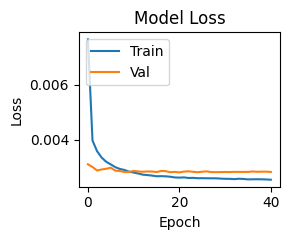

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0134 - val_loss: 0.0030
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.0036 - val_loss: 0.0029
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0032 - val_loss: 0.0028
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0028 - val_loss: 0.0028

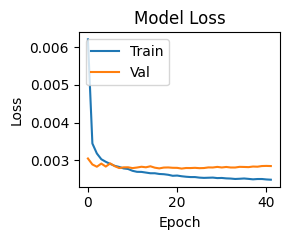

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0111 - val_loss: 0.0031
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0027 - val_loss: 0.0029

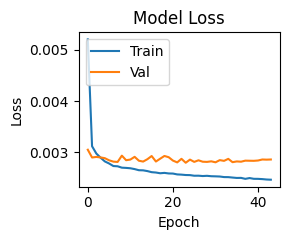

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0131 - val_loss: 0.0031
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 0.0038 - val_loss: 0.0031
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.0033 - val_loss: 0.0029
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.0028 - val_loss: 0.0029

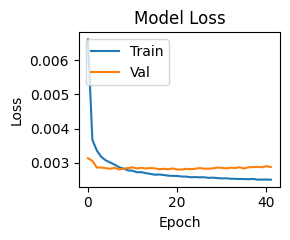

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0101 - val_loss: 0.0031
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.0027 - val_loss: 0.0029

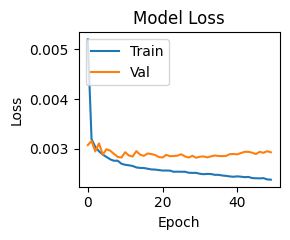

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0075 - val_loss: 0.0032
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.0029 - val_loss: 0.0031
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0027 - val_loss: 0.0029

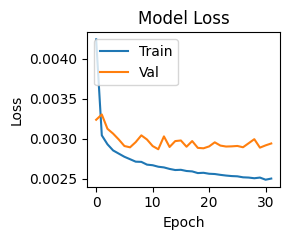

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0131 - val_loss: 0.0032
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.0028 - val_loss: 0.0028
Epo

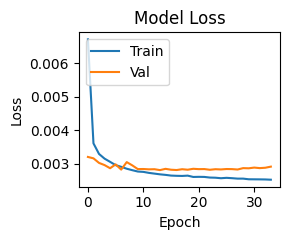

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0115 - val_loss: 0.0032
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 12/

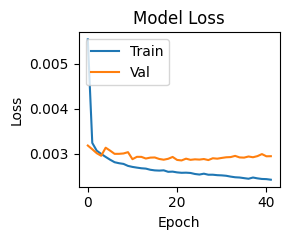

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0086 - val_loss: 0.0033
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 12/

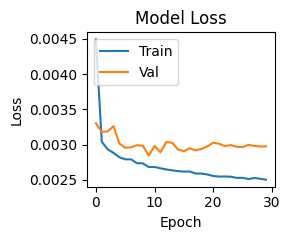

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,epochs,time/s,best_hyperparameter
0,2,64,2,128,0.002803,20,9.119094,False
1,2,64,2,256,0.002782,21,9.164527,True
2,2,64,2,512,0.002798,23,9.240796,False
3,2,64,3,128,0.002797,21,9.528874,False
4,2,64,3,256,0.002825,29,10.767893,False
5,2,64,3,512,0.002867,11,8.031152,False
6,2,64,4,128,0.002802,13,8.559916,False
7,2,64,4,256,0.002847,21,10.531260,False
8,2,64,4,512,0.002844,9,8.844673,False


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0155 - val_loss: 0.0034
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0039 - val_loss: 0.0032
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0037 - val_loss: 0.0033
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.0031 - val_loss: 0.0031
E

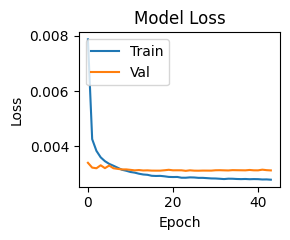

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0135 - val_loss: 0.0033
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.0034 - val_loss: 0.0032
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.0031 - val_loss: 0.0031
E

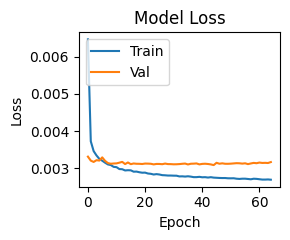

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0111 - val_loss: 0.0032
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0030 - val_loss: 0.0032
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0030 - val_loss: 0.0033
E

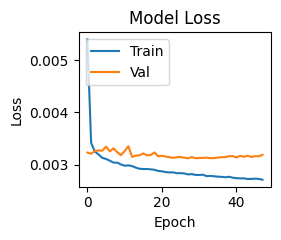

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0133 - val_loss: 0.0033
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 0.0037 - val_loss: 0.0032
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0031 - val_loss: 0.0031
E

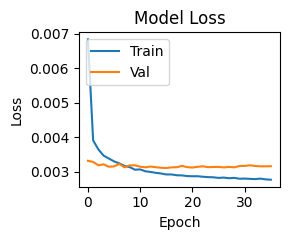

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0102 - val_loss: 0.0035
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0035 - val_loss: 0.0038
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0033 - val_loss: 0.0035
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0030 - val_loss: 0.0032
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0030 - val_loss: 0.0033
E

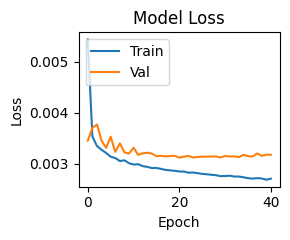

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0077 - val_loss: 0.0040
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.0033 - val_loss: 0.0036
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 0.0030 - val_loss: 0.0036
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.0030 - val_loss: 0.0037
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.0030 - val_loss: 0.0037
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.0030 - val_loss: 0.0035
E

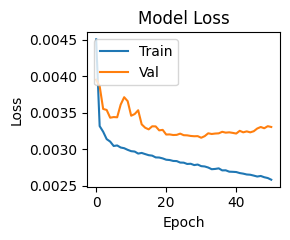

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0130 - val_loss: 0.0035
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0031 - val_loss: 0.0032
E

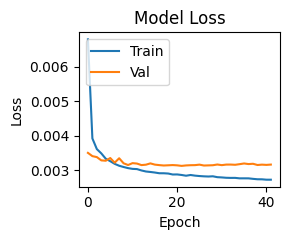

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0116 - val_loss: 0.0035
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.0034 - val_loss: 0.0035
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.0033 - val_loss: 0.0036
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.0033 - val_loss: 0.0037
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.0032 - val_loss: 0.0034
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.0031 - val_loss: 0.0035
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 0.0031 - val_loss: 0.0035
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0033
Ep

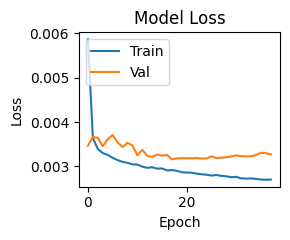

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0086 - val_loss: 0.0040
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0034 - val_loss: 0.0037
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.0032 - val_loss: 0.0039
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0032 - val_loss: 0.0034
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0031 - val_loss: 0.0035
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0031 - val_loss: 0.0035
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.0030 - val_loss: 0.0035
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.0030 - val_loss: 0.0037
Ep

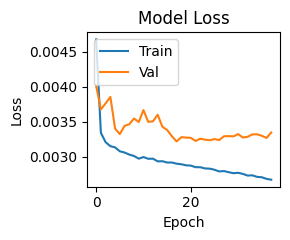

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,epochs,time/s,best_hyperparameter
0,2,64,2,128,0.003107,23,9.123870,False
1,2,64,2,256,0.003090,44,13.590364,True
2,2,64,2,512,0.003120,27,10.095367,False
3,2,64,3,128,0.003107,15,8.287256,False
4,2,64,3,256,0.003122,20,9.106685,False
5,2,64,3,512,0.003156,30,11.445984,False
6,2,64,4,128,0.003121,21,9.755342,False
7,2,64,4,256,0.003159,17,9.470820,False
8,2,64,4,512,0.003221,17,9.323128,False


['../../../checkpoints/physionet/tuning/2023/all_rue_predictor_best_hp.joblib']

In [ ]:
if seed == tuning_seed:
    all_rue_predictor_best_hp = {}
    for time_label, target_cols in tqdm(split_dict["target_cols"].items()):
        rue_predictor_tuning_df, rue_predictor_best_hp = model_tuning_regressor(
            param_grid = {
                "encoder_width": [128, 256, 512],
                "encoder_depth": [2, 3, 4],
                "decoder_width":[64],
                "decoder_depth": [2],
            }, predictors=split_dict["feat_cols"], pred_cols=target_cols, 
            train_df=split_dict["train_df"], valid_df=split_dict["valid_df"], seed=seed,
            batch_size=batch_size, max_epochs=10000, verbose=1, patience=20
        )
        display(rue_predictor_tuning_df)
        rue_predictor_tuning_df.to_csv(join(fp_cur_tune_folder, f"tuning_rue_{time_label}.csv"))
        all_rue_predictor_best_hp[time_label] = rue_predictor_best_hp
    joblib.dump(all_rue_predictor_best_hp, join(fp_cur_tune_folder, "all_rue_predictor_best_hp.joblib"))
    all_rue_predictor_best_hp

{'t+1': {'decoder_depth': 2,
  'decoder_width': 64,
  'encoder_depth': 2,
  'encoder_width': 128},
 't+2': {'decoder_depth': 2,
  'decoder_width': 64,
  'encoder_depth': 2,
  'encoder_width': 256},
 't+3': {'decoder_depth': 2,
  'decoder_width': 64,
  'encoder_depth': 2,
  'encoder_width': 256}}

## Train

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0152 - val_loss: 0.0025
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0032 - val_loss: 0.0023
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0029 - val_loss: 0.0024
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0023 - val_loss: 0.0023

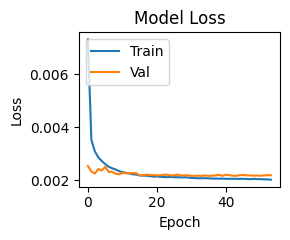

Training took 11.461775779724121s.
Model saved!
Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0134 - val_loss: 0.0030
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.0036 - val_loss: 0.0029
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0032 - val_loss: 0.0028
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━

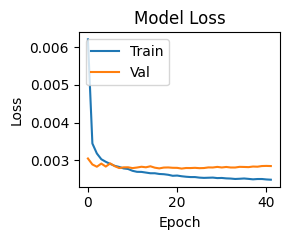

Training took 8.765896797180176s.
Model saved!
Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0135 - val_loss: 0.0033
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.0034 - val_loss: 0.0032
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s

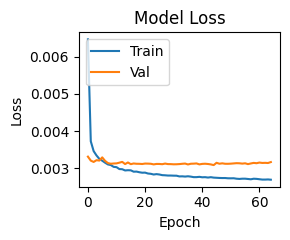

Training took 12.972092866897583s.
Model saved!


In [37]:
all_rue_predictor_best_hp = joblib.load(join(fp_cur_tune_folder, "all_rue_predictor_best_hp.joblib"))
for time_label, target_cols in tqdm(split_dict["target_cols"].items()):
    best_predictor_hp = all_rue_predictor_best_hp[time_label]
    ae_regressor = model_training_predictor(
        best_predictor_hp, 
        predictors=split_dict["feat_cols"], pred_cols=target_cols, 
        train_df=split_dict["train_df"], valid_df = split_dict["valid_df"], seed=seed,
        batch_size=batch_size, max_epochs=10000, verbose=1, patience=20
    ) 
    save_model(
        model=ae_regressor, name=f"rue_predictor_{time_label}", 
        fp_checkpoints=fp_cur_model_folder, override=True)

# Tune and Train Decoder

## Tune

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.9062 - val_loss: 0.1614
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1008 - val_loss: 0.0167
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0111 - val_loss: 0.0059
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.0049 - val_loss: 0.0054
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.0047 - val_loss: 0.0053
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.0046 - val_loss: 0.0052
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0045 - val_loss: 0.0051
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0044 - val_loss: 0.0049
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.0043 - val_loss: 0.0048
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0041 - val_loss: 0.0045
Epoch 12/10000
91/91 ━

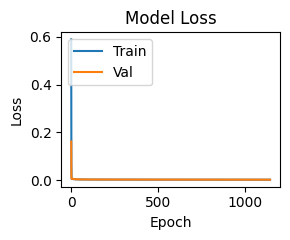

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.1026 - val_loss: 0.1206
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0676 - val_loss: 0.0085
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0062 - val_loss: 0.0053
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.0046 - val_loss: 0.0052
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0045 - val_loss: 0.0051
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.0044 - val_loss: 0.0049
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.0043 - val_loss: 0.0048
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0039 - val_loss: 0.0043
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0038 - val_loss: 0.0042
Epoch 12/10000
91/91 ━

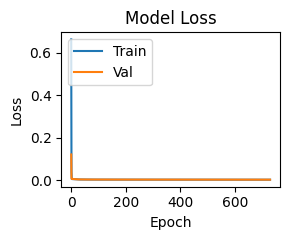

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.1696 - val_loss: 0.0519
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0255 - val_loss: 0.0055
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0047 - val_loss: 0.0052
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0045 - val_loss: 0.0051
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0044 - val_loss: 0.0048
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 0.0037 - val_loss: 0.0040
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0035 - val_loss: 0.0039
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0034 - val_loss: 0.0038
Epoch 12/10000
91/91 ━

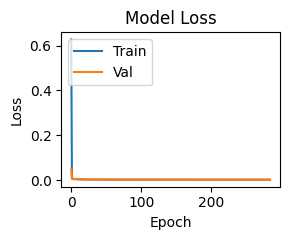

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.7643 - val_loss: 0.3201
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.1986 - val_loss: 0.0286
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.0179 - val_loss: 0.0067
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 0.0055 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 12/10000
91/91 ━

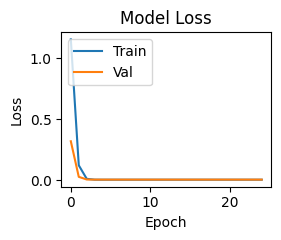

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.5849 - val_loss: 0.2205
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1169 - val_loss: 0.0099
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.0069 - val_loss: 0.0058
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 12/10000
91/91 ━

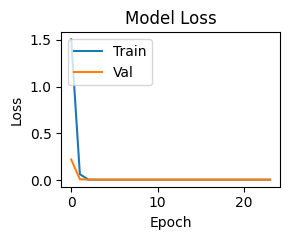

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.6922 - val_loss: 0.0763
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0342 - val_loss: 0.0060
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 12/10000
91/91 ━

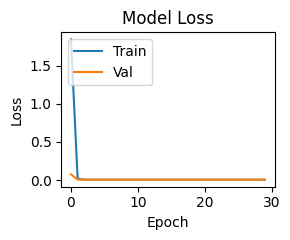

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.6241 - val_loss: 0.4771
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2953 - val_loss: 0.0398
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0242 - val_loss: 0.0071
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.0057 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 12/10000
91/91 ━━━━━━━━━━━

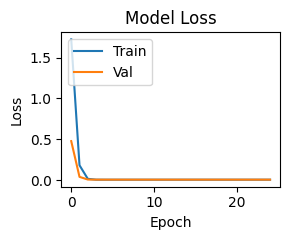

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 4.0912 - val_loss: 0.3213
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1665 - val_loss: 0.0109
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0074 - val_loss: 0.0058
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 12/10000
91/91 ━

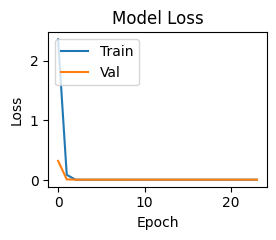

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.2150 - val_loss: 0.1001
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 0.0424 - val_loss: 0.0059
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 12/10000
91/91

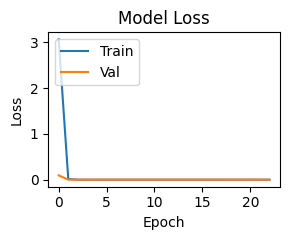

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,corr,epochs,time/s,best_hyperparameter
0,2,128,2,128,0.001588,0.242052,1127,111.293270,False
1,2,256,2,128,0.001829,0.251919,709,71.533643,False
2,2,512,2,128,0.002100,0.261860,264,29.800122,True
3,3,128,2,128,0.005796,0.154678,4,5.144563,False
4,3,256,2,128,0.005798,0.155897,3,5.290128,False
5,3,512,2,128,0.005850,0.144023,9,5.711678,False
6,4,128,2,128,0.005794,0.154745,4,5.748064,False
7,4,256,2,128,0.005796,0.155644,3,5.468309,False
8,4,512,2,128,0.005825,0.147425,2,5.375649,False


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1092 - val_loss: 0.1206
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0676 - val_loss: 0.0086
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 0.0062 - val_loss: 0.0052
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.0045 - val_loss: 0.0049
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0043 - val_loss: 0.0047
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 0.0040 - val_loss: 0.0045
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0039 - val_loss: 0.0043
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0038 - val_loss: 0.0042
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.0037 - val_loss: 0.0042
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0037 - val_loss: 0.0041
Epoch 12/10000
91/91 ━

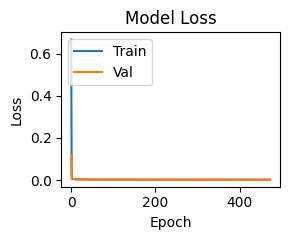

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.5320 - val_loss: 0.1047
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0536 - val_loss: 0.0064
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 0.0051 - val_loss: 0.0052
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0045 - val_loss: 0.0050
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.0044 - val_loss: 0.0048
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0040 - val_loss: 0.0045
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.0039 - val_loss: 0.0043
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0038 - val_loss: 0.0041
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0036 - val_loss: 0.0040
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0035 - val_loss: 0.0039
Epoch 12/10000
91/91

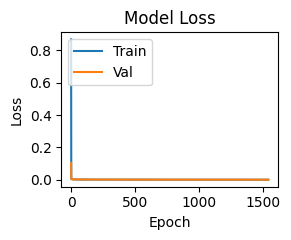

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.8430 - val_loss: 0.0515
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.0236 - val_loss: 0.0053
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.0045 - val_loss: 0.0049
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0043 - val_loss: 0.0046
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0038 - val_loss: 0.0042
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0037 - val_loss: 0.0040
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0035 - val_loss: 0.0039
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.0034 - val_loss: 0.0037
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.0032 - val_loss: 0.0036
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.0031 - val_loss: 0.0035
Epoch 12/10000
91/91

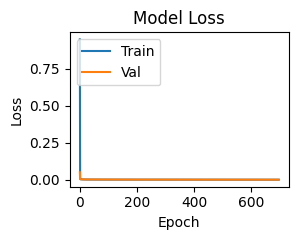

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.9683 - val_loss: 0.2793
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.1654 - val_loss: 0.0204
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0130 - val_loss: 0.0063
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0053 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 12/10000
91/91

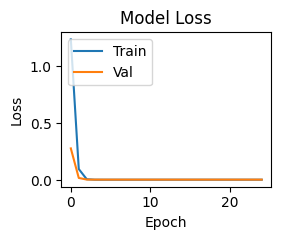

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.0162 - val_loss: 0.2046
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1029 - val_loss: 0.0078
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.0059 - val_loss: 0.0058
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 12/10000
91/91 ━

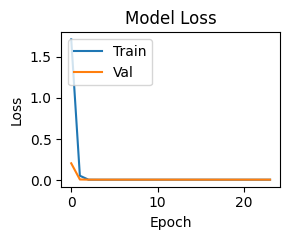

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 4.3659 - val_loss: 0.0758
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0322 - val_loss: 0.0059
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 12/10000
91/91 ━

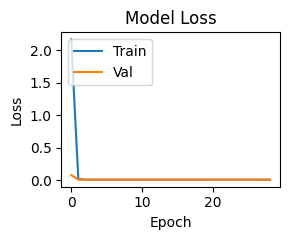

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.8287 - val_loss: 0.4365
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.2622 - val_loss: 0.0317
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 0.0194 - val_loss: 0.0067
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.0055 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 12/10000
91/91

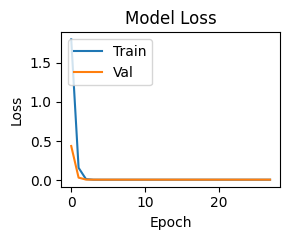

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.5230 - val_loss: 0.3053
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1524 - val_loss: 0.0088
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0063 - val_loss: 0.0058
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 12/10000
91/91 ━━━━━━━

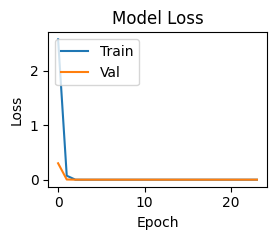

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.8896 - val_loss: 0.0996
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0404 - val_loss: 0.0058
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 12/10000
91/91 ━━━

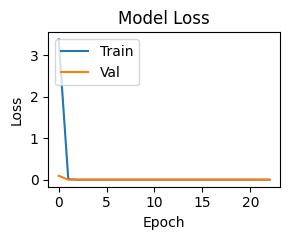

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,corr,epochs,time/s,best_hyperparameter
0,2,128,2,256,0.001770,0.201907,452,47.142807,True
1,2,256,2,256,0.001235,0.184962,1517,143.001159,False
2,2,512,2,256,0.001513,0.197118,676,66.629379,False
3,3,128,2,256,0.005796,0.112033,4,5.206476,False
4,3,256,2,256,0.005801,0.113227,3,4.575747,False
5,3,512,2,256,0.005852,0.098574,8,5.754451,False
6,4,128,2,256,0.005793,0.112347,7,6.129928,False
7,4,256,2,256,0.005796,0.113123,3,4.885454,False
8,4,512,2,256,0.005824,0.103667,2,6.106993,False


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1101 - val_loss: 0.1206
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.0676 - val_loss: 0.0085
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.0061 - val_loss: 0.0053
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0046 - val_loss: 0.0052
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0045 - val_loss: 0.0051
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0044 - val_loss: 0.0050
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0043 - val_loss: 0.0048
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0040 - val_loss: 0.0045
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0039 - val_loss: 0.0043
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 0.0038 - val_loss: 0.0042
Epoch 12/10000
91/91

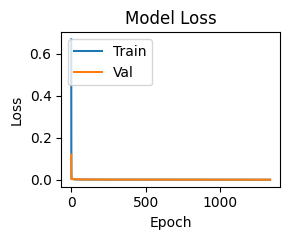

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5328 - val_loss: 0.1047
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.0535 - val_loss: 0.0063
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.0050 - val_loss: 0.0052
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 0.0045 - val_loss: 0.0051
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.0044 - val_loss: 0.0049
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0042 - val_loss: 0.0046
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0039 - val_loss: 0.0043
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 0.0037 - val_loss: 0.0041
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0036 - val_loss: 0.0040
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.0035 - val_loss: 0.0039
Epoch 12/10000
91/91

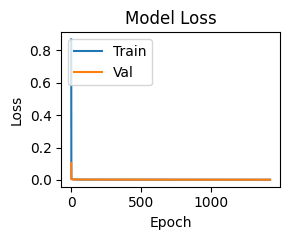

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.8438 - val_loss: 0.0514
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0235 - val_loss: 0.0052
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.0045 - val_loss: 0.0050
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0043 - val_loss: 0.0047
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.0041 - val_loss: 0.0045
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.0037 - val_loss: 0.0040
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0035 - val_loss: 0.0038
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.0033 - val_loss: 0.0037
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 12/10000
91/91

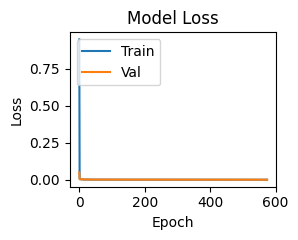

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.9679 - val_loss: 0.2793
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1654 - val_loss: 0.0204
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0063
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 12/10000
91/91 ━━━━━━━━━━━

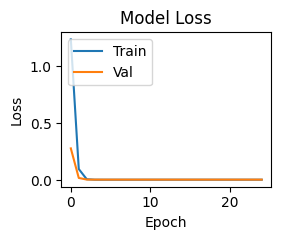

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.0166 - val_loss: 0.2046
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.1029 - val_loss: 0.0078
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.0059 - val_loss: 0.0058
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 12/10000
91/91 ━━━

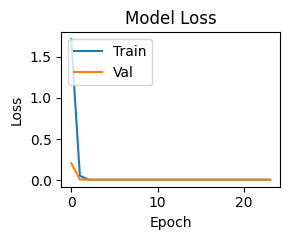

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4.3659 - val_loss: 0.0757
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.0322 - val_loss: 0.0059
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 12/10000
91/91 ━━━

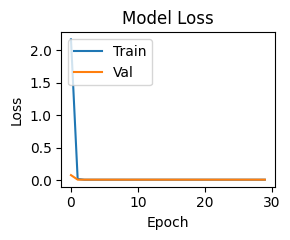

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.8280 - val_loss: 0.4362
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2620 - val_loss: 0.0317
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0194 - val_loss: 0.0067
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 12/10000
91/91 ━━━━━━━━━━━━━━━━━

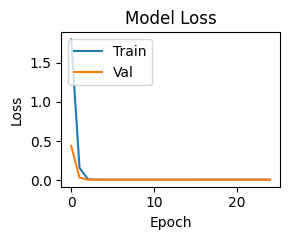

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.5227 - val_loss: 0.3054
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1524 - val_loss: 0.0088
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 12/10000
91/91 ━━━━━━━━━

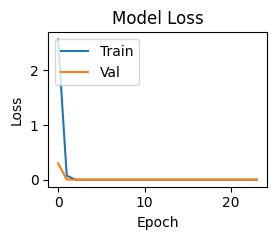

Epoch 1/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.8894 - val_loss: 0.0996
Epoch 2/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0404 - val_loss: 0.0058
Epoch 3/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 4/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 5/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 6/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 7/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 8/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 9/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 0.0051 - val_loss: 0.0059
Epoch 10/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 11/10000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 12/10000
91/91 ━━━━━━━

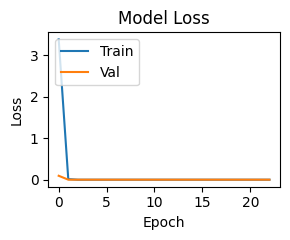

,decoder_depth,decoder_width,encoder_depth,encoder_width,loss,corr,epochs,time/s,best_hyperparameter
0,2,128,2,256,0.001415,0.225512,1313,124.895267,False
1,2,256,2,256,0.001381,0.222406,1404,138.119534,False
2,2,512,2,256,0.001571,0.228876,554,62.326535,True
3,3,128,2,256,0.005798,0.129079,4,5.455242,False
4,3,256,2,256,0.005800,0.129519,3,4.701868,False
5,3,512,2,256,0.005849,0.114689,9,5.961200,False
6,4,128,2,256,0.005793,0.128976,4,5.988879,False
7,4,256,2,256,0.005796,0.129713,3,5.003762,False
8,4,512,2,256,0.005830,0.117899,2,5.678606,False


['../../checkpoints/physionet/tuning/all_rue_decoder_best_hp.joblib']

In [ ]:
if seed == tuning_seed:
    all_rue_predictor_best_hp = joblib.load(join(fp_cur_tune_folder, "all_rue_predictor_best_hp.joblib"))
    all_rue_decoder_best_hp = {}
    for time_label, target_cols in tqdm(split_dict["target_cols"].items()):
        best_predictor_hp = all_rue_predictor_best_hp[time_label]
        prev_model = load_model(
            name=f"rue_predictor_{time_label}", fp_checkpoints=fp_cur_model_folder)
        rue_tuning_df, rue_decoder_best_hp = model_tuning_decoder(
            param_grid=dict(
                encoder_width = [best_predictor_hp["encoder_width"]], 
                encoder_depth = [best_predictor_hp["encoder_depth"]],
                decoder_width =[128, 256, 512],
                decoder_depth = [2, 3, 4],
            ), predictors=split_dict["feat_cols"], pred_cols=target_cols, 
            train_df=split_dict["train_df"], valid_df=split_dict["valid_df"], seed=seed,
            max_epochs=10000, verbose=1, patience=20, prev_model=prev_model
        )
        display(rue_tuning_df)
        rue_tuning_df.to_csv(join(fp_cur_tune_folder, f"tuning_rue_decoder_{time_label}.csv"))
        all_rue_decoder_best_hp[time_label] = rue_decoder_best_hp
    joblib.dump(all_rue_decoder_best_hp, join(fp_cur_tune_folder, "all_rue_decoder_best_hp.joblib"))
    all_rue_decoder_best_hp

{'t+1': {'decoder_depth': 2,
  'decoder_width': 512,
  'encoder_depth': 2,
  'encoder_width': 128},
 't+2': {'decoder_depth': 2,
  'decoder_width': 128,
  'encoder_depth': 2,
  'encoder_width': 256},
 't+3': {'decoder_depth': 2,
  'decoder_width': 512,
  'encoder_depth': 2,
  'encoder_width': 256}}

## Train

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8044 - val_loss: 0.0055
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0047 - val_loss: 0.0051
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0043 - val_loss: 0.0046
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0037 - val_loss: 0.0039
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0034 - val_loss: 0.0037
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0029 - val_loss: 0.0032
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.0028 - val_loss: 0.0032

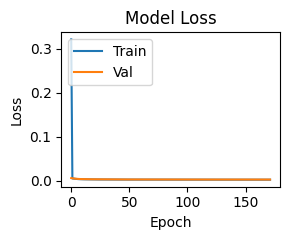

Training took 30.622857570648193s.
Model saved!


Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7937 - val_loss: 0.0086
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.0057 - val_loss: 0.0053
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0046 - val_loss: 0.0050
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0043 - val_loss: 0.0047
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.0041 - val_loss: 0.0044
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.0037 - val_loss: 0.0041
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.0036 - val_loss: 0.0039
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.0034 - val_loss: 0.0038
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.0033 - val_loss: 0.0037
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0032 - val_loss: 0.0036

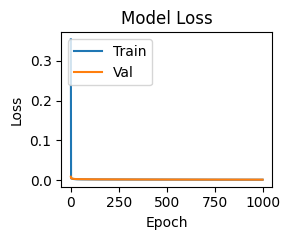

Training took 166.07620286941528s.
Model saved!


Epoch 1/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.2523 - val_loss: 0.0053
Epoch 2/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0045 - val_loss: 0.0048
Epoch 3/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.0041 - val_loss: 0.0043
Epoch 4/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0037 - val_loss: 0.0039
Epoch 5/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0034 - val_loss: 0.0037
Epoch 6/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 7/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 8/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0029 - val_loss: 0.0032
Epoch 9/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0028 - val_loss: 0.0031
Epoch 10/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0027 - val_loss: 0.0030
Epoch 11/10000
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.0026 - val_loss: 0.0030

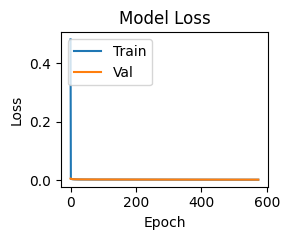

Training took 95.6350622177124s.


Model saved!


In [47]:
all_rue_decoder_best_hp = joblib.load(join(fp_cur_tune_folder, "all_rue_decoder_best_hp.joblib"))
for time_label, target_cols in tqdm(split_dict["target_cols"].items()):
    prev_model = load_model(
        name=f"rue_predictor_{time_label}", fp_checkpoints=fp_cur_model_folder)
    hp_dict = all_rue_decoder_best_hp[time_label]
    ae_regressor = model_training_decoder(
        hp_dict, predictors=split_dict["feat_cols"], pred_cols=target_cols, 
        train_df=split_dict["train_df"], valid_df = split_dict["valid_df"], 
        seed=seed, prev_model=prev_model,
        batch_size=batch_size, max_epochs=10000, verbose=1, patience=20
    ) 
    save_model(model=ae_regressor, name=f"rue_{time_label}", 
               fp_checkpoints=fp_cur_model_folder, override=True)

# Prediction

In [49]:
for time_label, target_cols in tqdm(split_dict["target_cols"].items()):
    ae_regressor = load_model(name=f"rue_{time_label}", fp_checkpoints=fp_cur_model_folder)
    rue_valid_df = model_test_predictions(
        ae_regressor, df_train=split_dict["train_df"], df_test=split_dict["valid_df"], 
        pred_cols=target_cols, predictors=split_dict["feat_cols"], 
        regressor_label="_"+time_label, pred_min=int(time_label[-1]), T=10, seed=seed)
    rue_test_df = model_test_predictions(
        ae_regressor, 
        df_train=split_dict["train_df"], df_test=split_dict["test_df"], 
        pred_cols=target_cols, predictors=split_dict["feat_cols"], 
        regressor_label="_"+time_label, pred_min=int(time_label[-1]), T=10, seed=seed)
    display(rue_test_df)
    rue_valid_df.to_csv(join(fp_cur_predictions_folder, f"rue_valid_{time_label[-1]}.csv"))
    rue_test_df.to_csv(join(fp_cur_predictions_folder, f"rue_test_{time_label[-1]}.csv"))


  0%|          | 0/3 [00:00<?, ?it/s]

,HR_t-4,SysABP_t-4,DiasABP_t-4,MAP_t-4,Urine_t-4,time_t-4,HR_t-3,SysABP_t-3,DiasABP_t-3,MAP_t-3,...,SysABP_t+1_mean_t+1,DiasABP_t+1_mean_t+1,MAP_t+1_mean_t+1,Urine_t+1_mean_t+1,HR_t+1_std_t+1,SysABP_t+1_std_t+1,DiasABP_t+1_std_t+1,MAP_t+1_std_t+1,Urine_t+1_std_t+1,mcd
0,0.295699,0.405303,0.192157,0.267148,0.240,33.783333,0.333333,0.443182,0.207843,0.296029,...,0.390104,0.180912,0.257356,0.120627,0.010788,0.012869,0.005505,0.003923,0.007488,0.008115
1,0.333333,0.443182,0.207843,0.296029,0.260,34.783333,0.290323,0.405303,0.192157,0.270758,...,0.382490,0.179953,0.255600,0.109725,0.014880,0.010678,0.005515,0.005564,0.008185,0.008964
2,0.290323,0.405303,0.192157,0.270758,0.200,35.783333,0.279570,0.375000,0.172549,0.245487,...,0.388793,0.185557,0.261959,0.146211,0.010971,0.008566,0.004448,0.003362,0.007822,0.007034
3,0.279570,0.375000,0.172549,0.245487,0.100,36.783333,0.290323,0.386364,0.180392,0.259928,...,0.392569,0.192414,0.266149,0.146254,0.010486,0.008321,0.004560,0.004780,0.007582,0.007146
4,0.290323,0.386364,0.180392,0.259928,0.100,37.783333,0.322581,0.371212,0.184314,0.259928,...,0.388166,0.193989,0.267899,0.139672,0.009425,0.007860,0.005281,0.005494,0.008303,0.007273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.430108,0.465909,0.152941,0.234657,0.010,36.183333,0.376344,0.390152,0.141176,0.234657,...,0.441233,0.160846,0.255140,0.035876,0.010549,0.011331,0.003801,0.004075,0.007950,0.007541
5,0.376344,0.390152,0.141176,0.234657,0.025,37.183333,0.365591,0.401515,0.141176,0.238267,...,0.446568,0.163986,0.256641,0.050905,0.006926,0.015828,0.003601,0.006605,0.005469,0.007686
6,0.365591,0.401515,0.141176,0.238267,0.033,38.183333,0.376344,0.462121,0.156863,0.267148,...,0.437749,0.154978,0.248979,0.060500,0.006903,0.009736,0.003844,0.004350,0.004630,0.005893
7,0.376344,0.462121,0.156863,0.267148,0.030,39.183333,0.365591,0.439394,0.152941,0.259928,...,0.436840,0.152189,0.245525,0.044431,0.006266,0.010630,0.005204,0.005378,0.006605,0.006816


,HR_t-4,SysABP_t-4,DiasABP_t-4,MAP_t-4,Urine_t-4,time_t-4,HR_t-3,SysABP_t-3,DiasABP_t-3,MAP_t-3,...,SysABP_t+2_mean_t+2,DiasABP_t+2_mean_t+2,MAP_t+2_mean_t+2,Urine_t+2_mean_t+2,HR_t+2_std_t+2,SysABP_t+2_std_t+2,DiasABP_t+2_std_t+2,MAP_t+2_std_t+2,Urine_t+2_std_t+2,mcd
0,0.295699,0.405303,0.192157,0.267148,0.240,33.783333,0.333333,0.443182,0.207843,0.296029,...,0.402427,0.186447,0.258707,0.099481,0.006591,0.008094,0.005454,0.005294,0.005820,0.006251
1,0.333333,0.443182,0.207843,0.296029,0.260,34.783333,0.290323,0.405303,0.192157,0.270758,...,0.386781,0.183408,0.253169,0.102877,0.004548,0.005992,0.003256,0.003836,0.005581,0.004643
2,0.290323,0.405303,0.192157,0.270758,0.200,35.783333,0.279570,0.375000,0.172549,0.245487,...,0.388988,0.186531,0.256475,0.118821,0.007919,0.009815,0.007515,0.006338,0.006403,0.007598
3,0.279570,0.375000,0.172549,0.245487,0.100,36.783333,0.290323,0.386364,0.180392,0.259928,...,0.395480,0.194152,0.266053,0.115231,0.010720,0.007415,0.004960,0.005827,0.005552,0.006895
4,0.290323,0.386364,0.180392,0.259928,0.100,37.783333,0.322581,0.371212,0.184314,0.259928,...,0.400446,0.198321,0.269093,0.117544,0.007692,0.006345,0.005091,0.004436,0.008182,0.006349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.430108,0.465909,0.152941,0.234657,0.010,36.183333,0.376344,0.390152,0.141176,0.234657,...,0.451879,0.160224,0.254131,0.032672,0.008373,0.009128,0.003902,0.003409,0.001992,0.005361
5,0.376344,0.390152,0.141176,0.234657,0.025,37.183333,0.365591,0.401515,0.141176,0.238267,...,0.455149,0.159192,0.254422,0.049905,0.011065,0.012873,0.004929,0.005274,0.005575,0.007943
6,0.365591,0.401515,0.141176,0.238267,0.033,38.183333,0.376344,0.462121,0.156863,0.267148,...,0.441700,0.154241,0.248399,0.062517,0.012240,0.009585,0.003008,0.003033,0.005098,0.006593
7,0.376344,0.462121,0.156863,0.267148,0.030,39.183333,0.365591,0.439394,0.152941,0.259928,...,0.450944,0.147887,0.246693,0.045818,0.003556,0.009444,0.005501,0.005471,0.005122,0.005819


,HR_t-4,SysABP_t-4,DiasABP_t-4,MAP_t-4,Urine_t-4,time_t-4,HR_t-3,SysABP_t-3,DiasABP_t-3,MAP_t-3,...,SysABP_t+3_mean_t+3,DiasABP_t+3_mean_t+3,MAP_t+3_mean_t+3,Urine_t+3_mean_t+3,HR_t+3_std_t+3,SysABP_t+3_std_t+3,DiasABP_t+3_std_t+3,MAP_t+3_std_t+3,Urine_t+3_std_t+3,mcd
0,0.295699,0.405303,0.192157,0.267148,0.240,33.783333,0.333333,0.443182,0.207843,0.296029,...,0.398042,0.179206,0.255372,0.118683,0.005055,0.008318,0.005173,0.003757,0.008873,0.006235
1,0.333333,0.443182,0.207843,0.296029,0.260,34.783333,0.290323,0.405303,0.192157,0.270758,...,0.387715,0.177459,0.253005,0.121052,0.006476,0.004189,0.003680,0.002966,0.004630,0.004388
2,0.290323,0.405303,0.192157,0.270758,0.200,35.783333,0.279570,0.375000,0.172549,0.245487,...,0.388681,0.181686,0.256530,0.128148,0.006898,0.005447,0.004853,0.005995,0.008252,0.006289
3,0.279570,0.375000,0.172549,0.245487,0.100,36.783333,0.290323,0.386364,0.180392,0.259928,...,0.402824,0.191354,0.267703,0.127859,0.007587,0.006632,0.004419,0.004596,0.005244,0.005696
4,0.290323,0.386364,0.180392,0.259928,0.100,37.783333,0.322581,0.371212,0.184314,0.259928,...,0.395082,0.191578,0.267096,0.137791,0.005142,0.004898,0.003318,0.002979,0.006933,0.004654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.430108,0.465909,0.152941,0.234657,0.010,36.183333,0.376344,0.390152,0.141176,0.234657,...,0.447257,0.151224,0.252516,0.042835,0.006697,0.007886,0.004890,0.004262,0.004042,0.005555
5,0.376344,0.390152,0.141176,0.234657,0.025,37.183333,0.365591,0.401515,0.141176,0.238267,...,0.449417,0.154481,0.254027,0.053055,0.006508,0.008450,0.003074,0.005786,0.003237,0.005411
6,0.365591,0.401515,0.141176,0.238267,0.033,38.183333,0.376344,0.462121,0.156863,0.267148,...,0.442138,0.152374,0.250755,0.063816,0.005428,0.005759,0.002167,0.003219,0.003734,0.004061
7,0.376344,0.462121,0.156863,0.267148,0.030,39.183333,0.365591,0.439394,0.152941,0.259928,...,0.450739,0.146983,0.249046,0.058756,0.003981,0.007230,0.004081,0.003860,0.002585,0.004347
